In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from  process import *

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import joblib

In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
train = pd.read_parquet(Path('../data/preprocessed/adv_train.pq'))
test = pd.read_parquet(Path('../data/preprocessed/adv_test.pq'))

In [7]:
#extra date feature
train, test = set_age2(train, test)

In [10]:
#features form bert
train1 = joblib.load(Path('../data/preprocessed/train_pred1.bin'))
train2 = joblib.load(Path('../data/preprocessed/train_pred2.bin'))
test1 = joblib.load(Path('../data/preprocessed/pred1.bin'))
test2 = joblib.load(Path('../data/preprocessed/pred2.bin'))
train['rbrt'] = train1
train['rbrt_sent'] = train2
test['rbrt'] = test1
test['rbrt_sent'] = test2

In [11]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [12]:
train_n = train.drop(columns=DROP_FEATURES)
test_n = test.drop(columns=DROP_FEATURES)

In [13]:
class Tuner:
    """
    Search best hyperparameters for model.
    """

    def __init__(self, model, train_pool, val_pool, space, common_params={}, fit_params={}, int_params=[]):
        """
        Initialization.

        Parameters:
            model (Model) - ML model with sklearn API.
            train_pool (catboost.Pool, dim=(n,m)) - training data.
            val_pool (catboost.Pool, dim=(k,m)) - validation data.
            space (dict) - space for searching hyperparameters.
            common_params (dict) - common model's parameters.
            fit_params (dict) - parameters for method 'fit'.
            int_params (list) - list of integer parameters.
        """
        
        self.__model = model
        self.__train_pool = train_pool
        self.__val_pool = val_pool
        self.__space = space
        self.__common_params = common_params
        self.__fit_params = fit_params
        self.__int_params = int_params
    

    def __params2int(self, params):
        """
        Transform some hyperopt formats to integer.

        Parameters:
            params (dict) - model parameters.
        """
        
        for par in self.__int_params:
            params[par] = int(params[par])

        return params
    

    def __score(self, params):
        """
        Compute score over dictionary of parameters.

        Parameters:
            params (dict) - model parameters.
        """

        model = self.__model(**self.__common_params, **self.__params2int(params))\
                    .fit(self.__train_pool, 
                         eval_set=self.__val_pool, 
                         **self.__fit_params)
        
        y_pred = model.predict(self.__val_pool)
        loss = RMSE(self.__val_pool.get_label(), y_pred)
        
        return {"loss": loss, "status": STATUS_OK}
    

    def make_hyperopt(self, max_evals=50):
        """
        Make searching of hyperparameters.

        Parameters:
            max_evals (int) - max number of iterations for optimization.
        """

        self.trials = Trials()
        best = fmin(self.__score,
                    space=self.__space,
                    trials=self.trials,
                    algo=tpe.suggest,
                    max_evals=max_evals)
        self.best_parameters = self.__params2int(best)

In [16]:
SPACE = {
    "iterations": hp.quniform("iterations", 100, 1200, 50),
    "learning_rate": hp.uniform("learning_rate", 1e-2, 5e-1),
    "depth": hp.quniform("depth", 3, 8, 1),
    
    "min_child_samples": hp.quniform("min_child_samples", 10, 150, 10),

    "reg_lambda": hp.uniform("reg_lambda", 0, 20),

    
     "random_strength": hp.lognormal("random_strength", 1e-9, 1),
     "bagging_temperature": hp.quniform("bagging_temperature", 0, 10, 1),

#    "colsample_bylevel": hp.uniform("colsample_bylevel", 0, 1),
#   "subsample": hp.uniform("subsample", 0, 1)
}

COMMON_PARAMS = {
    "random_state": 42,
    "task_type": "GPU",
    "objective": "RMSE",
    "eval_metric": "RMSE",
    
    "od_type": "Iter",
    "od_wait": 20,
    "use_best_model": True
}

FIT_PARAMS = {
    "verbose": 0
}

INT_PARAMS = [
    "iterations", "depth", "min_child_samples", #"bagging_temperature"
]


MODEL = CatBoostRegressor

In [50]:
X_train, X_val = train_test_split(train_n.drop(columns=['id']), train_size=0.7, random_state=42)

In [51]:
X_train = X_train[X_train.salary > 0].copy()

In [52]:
train_pool = Pool(X_train.drop(columns=['salary']), np.log(X_train['salary']+1), cat_features=CAT_FEATURES)

In [53]:
val_pool = Pool(X_val.drop(columns=['salary']), np.log(X_val['salary']+1), cat_features=CAT_FEATURES)

In [20]:
tuner = Tuner(MODEL, train_pool, val_pool, SPACE, COMMON_PARAMS, FIT_PARAMS, INT_PARAMS)
tuner.make_hyperopt(max_evals=200)

100%|████████████████████████████████████████████| 200/200 [1:05:15<00:00, 19.58s/trial, best loss: 0.9944795200030278]


In [21]:
tuner.best_parameters

{'bagging_temperature': 1.0,
 'depth': 6,
 'iterations': 150,
 'learning_rate': 0.16060632773346958,
 'min_child_samples': 70,
 'random_strength': 15.832233734896079,
 'reg_lambda': 9.247482837796273}

In [54]:
params ={'bagging_temperature': 1.0,
 'depth': 6,
 'iterations': 1000,
 'learning_rate': 0.16060632773346958,
 'min_child_samples': 70,
 'random_strength': 15.832233734896079,
 'reg_lambda': 9.247482837796273}

In [55]:
est = CatBoostRegressor(**params)

In [56]:
est.fit(train_pool, eval_set=val_pool, verbose_eval=100)

0:	learn: 0.5690882	test: 1.0795985	best: 1.0795985 (0)	total: 324ms	remaining: 5m 23s
100:	learn: 0.4242938	test: 1.0102916	best: 1.0102916 (100)	total: 27.2s	remaining: 4m 1s
200:	learn: 0.4159075	test: 1.0078383	best: 1.0078249 (199)	total: 1m	remaining: 4m 2s
300:	learn: 0.4126592	test: 1.0074286	best: 1.0074147 (297)	total: 1m 33s	remaining: 3m 36s
400:	learn: 0.4103452	test: 1.0071556	best: 1.0071556 (400)	total: 2m 6s	remaining: 3m 9s
500:	learn: 0.4086659	test: 1.0069937	best: 1.0069937 (500)	total: 2m 39s	remaining: 2m 38s
600:	learn: 0.4070673	test: 1.0069155	best: 1.0069069 (598)	total: 3m 12s	remaining: 2m 7s
700:	learn: 0.4054820	test: 1.0068028	best: 1.0068003 (699)	total: 3m 44s	remaining: 1m 35s
800:	learn: 0.4039843	test: 1.0067422	best: 1.0067174 (775)	total: 4m 17s	remaining: 1m 4s
900:	learn: 0.4028466	test: 1.0067169	best: 1.0067142 (899)	total: 4m 49s	remaining: 31.8s
999:	learn: 0.4016367	test: 1.0066818	best: 1.0066741 (957)	total: 5m 22s	remaining: 0us

bestTes

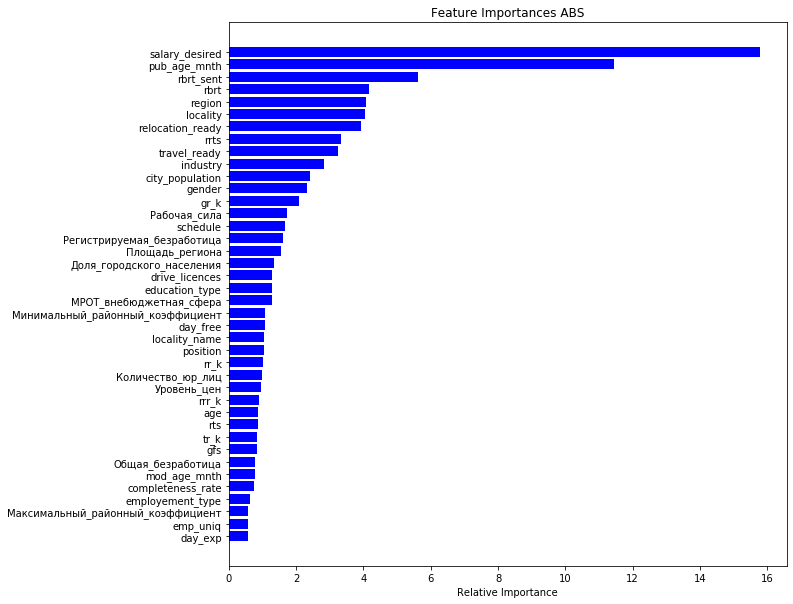

In [38]:
importance = sorted(zip(X_train.drop(columns=['salary']).columns, est.feature_importances_), key=lambda x: x[1], reverse=True)
imp = list(reversed(importance[:40]))
plt.figure(figsize=(10,10))
plt.title('Feature Importances ABS')
plt.barh(range(len(imp)), [x[1] for x in imp], color='b', align='center')
plt.yticks(range(len(imp)), [x[0] for x in imp])
plt.xlabel('Relative Importance')
plt.show()

In [39]:
np.sqrt(mean_squared_log_error(X_val['salary'], np.exp(est.predict(val_pool))-1))

0.9909416336074055

* 0.9972564465076517
* 0.99760837067426
* 0.997859426677459

In [40]:
np.sqrt(mean_squared_log_error(X_train['salary'], np.exp(est.predict(train_pool))-1))

0.9709994871716234

* 0.9985669695421593
* 0.966665672020638
* 0.9645155233472713

In [42]:
est.fit(train_n.drop(columns=['id', 'salary']), 
        np.log(train_n['salary']+1), 
        verbose_eval=100,
       cat_features=CAT_FEATURES)

0:	learn: 1.0846359	total: 368ms	remaining: 6m 7s
100:	learn: 1.0047121	total: 32.1s	remaining: 4m 45s
200:	learn: 0.9938665	total: 1m 8s	remaining: 4m 31s
300:	learn: 0.9900105	total: 1m 43s	remaining: 3m 59s
400:	learn: 0.9862826	total: 2m 20s	remaining: 3m 30s
500:	learn: 0.9838865	total: 2m 59s	remaining: 2m 58s
600:	learn: 0.9812107	total: 3m 35s	remaining: 2m 23s
700:	learn: 0.9791234	total: 4m 11s	remaining: 1m 47s
800:	learn: 0.9775342	total: 4m 48s	remaining: 1m 11s
900:	learn: 0.9754698	total: 5m 26s	remaining: 35.8s
999:	learn: 0.9731626	total: 6m 2s	remaining: 0us


In [43]:
np.sqrt(mean_squared_log_error(train_n['salary'], 
                               np.exp(est.predict(train_n.drop(columns=['id', 'salary'])))-1))

0.9697112577379957

* 0.9950571621055008
* 0.9678006684793359
* 0.9679435998332367

In [44]:
predict=np.exp(est.predict(test_n.drop(columns=['id'])))-1

In [45]:
sub = test_n[['id']].copy()

In [46]:
sub['salary'] = predict

In [47]:
sub.to_csv(Path('../submissions/cb_6_plus_brt_final_sub.csv'), index=False, sep=",")